In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#huggingface
!pip install transformers
!pip install PySastrawi
!pip install -q pyyaml h5py

     |████████████████████████████████| 3.5 MB 4.4 MB/s 
     |████████████████████████████████| 6.8 MB 36.6 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 210 kB 4.2 MB/s 


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.2 MB/s 


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
from numpy import interp
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing import sequence

import torch

# If there's a GPU available...   
device = torch.device("cuda")

In [ ]:
#LOAD DATASET , change this if u have another dataset
trainingagree=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/all_agree.csv')
trainingagree

,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0
...,...,...,...
8608,Twice Rilis Teaser MV 'Feel Special' Jelang Co...,clickbait,1
8609,"Asap Karhutla Riau Mulai Merambah Ke Nias, BM...",non-clickbait,0
8610,"Tolak RUU Pertanahan, Ribuan Petani Siap Gelar...",non-clickbait,0
8611,Ada Niat Tambah Momongan Tanpa Ikut Program Ha...,clickbait,1


3316
5297


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


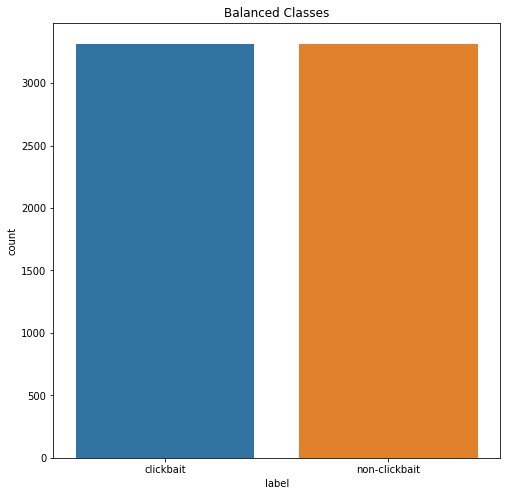

6632


In [ ]:
# UNDERSAMPLE IF NEEDED
clickbait = trainingagree.loc[trainingagree['label_score'] == 1]
print(len(clickbait))
nclickbait = trainingagree.loc[trainingagree['label_score'] == 0].sample(n=3316,random_state=22)
nclickbaitasli = trainingagree.loc[trainingagree['label_score'] == 0]
print(len(nclickbaitasli))
# Put all the fraud class in a separate dataset. ini yang kappa 0.4
#clickbait_df = training.loc[training['label_score'] == 1]
#print(len(clickbait_df))
#nclickbait_df = training.loc[training['label_score'] == 0].sample(n=6290,random_state=13)
#print(len(nclickbait_df))

#Randomly select 492 observations from the non-fraud (majority class)
#non_clickbait_df = training.loc[training['label'] == 0].sample(n=1393,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([clickbait, nclickbait])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('label', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#print(normalized_df)
tags = normalized_df.label_score
texts = normalized_df.title
#print(tags)

#texts
print(len(texts))

In [ ]:
#stemming INDO - no need with BERT TOkenizeR
#factory = StemmerFactory()
#stemmer= factory.create_stemmer()

#textstemss = []
textstem = []
textstemclick = []
textstemnon =[]
#for line in texts:
#  outstem = stemmer.stem(line)
#  textstemss.append(outstem)

#stopword remove
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
for line in clickbait['title']:
  stop = stopword.remove(line)
  textstemclick.append(stop)
for line in nclickbait['title']:
  stopa = stopword.remove(line)
  textstemnon.append(stopa)


for line in texts:
  stop = stopword.remove(line)
  textstem.append(stop)  
  #hapus angka
#from string import digits

#for line in textstems:
#    remove_digits=str.maketrans(' ', ' ', digits)
#    result=line.translate(remove_digits)
#    textstem.append(result)


print(textstem)
#print(texts)

#X_train, X_test, y_train, y_test = train_test_split(textstem, tags, test_size=0.1, random_state=42)
#print(len(X_train))

['Viral! Driver Ojol Bekasi Antar Pesanan Makanan Pakai Sepeda', 'Ada Motor Nyangkut Atas Bambu Sleman, Kok Bisa?', 'Pesan Gamblang Poyuono Menolak Revisi UU KPK', 'Kocak! Maling Rumah Mewah Jakut Terekam CCTV Bingung Cari Jalan Kabur', 'Viral Video Diduga Baku Tembak Sleman, Ini Kata Polisi', 'Waspada! Ada Penipuan Catut Pertamina, Korbannya Rugi Puluhan Juta', 'Jaksa Beberkan Senpi-Peluru Tajam Pembelian Kivlan Zen cs, Ini Rinciannya', 'Sering Quality Time Bersama Keluarga? Ternyata Ini 3 Manfaatnya!', 'Menteri Jokowi 55% Profesional, Ini Kandidatnya?', "Pria Misterius Berjubah Putih Viral Sumut, Ingatkan 'Tuhan Murka'", 'Video Porno Sumedang Disebar Pemeran Pria, Apa Motifnya?', 'Terungkap! Video Porno Sumedang Diperankan Pasangan Selingkuh', 'Kendaraan Listrik Bebas Aturan Ganjil-Genap, Ini Alasannya', 'Menanti "Kebijakan Gila" Jokowi', 'Akhirnya! Pemkot Pekanbaru Liburkan SD SMP Kabut Asap', '2 Ribu Hektare Lahan Terbakar, Udara Palembang Tidak Sehat!', 'Viral Bocah Bekasi Disebut

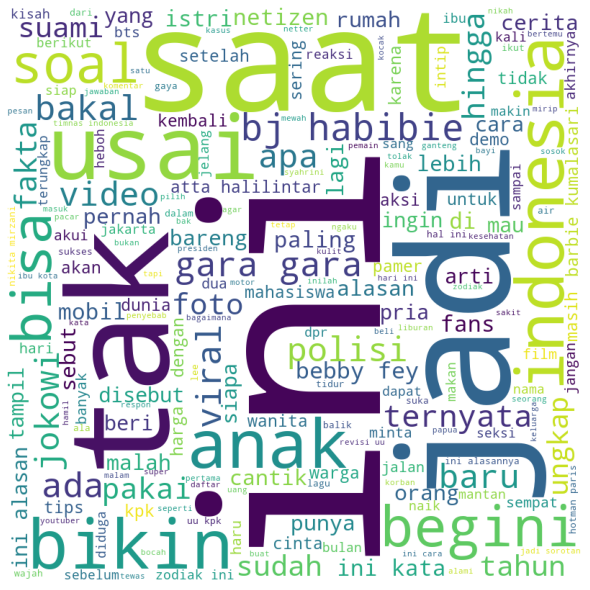

In [ ]:
#descriptive
from wordcloud import WordCloud, STOPWORDS 
comment_words = '' 

#in textstem  
# iterate through the csv file 
for val in textstemclick: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

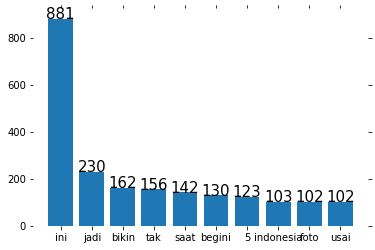

In [ ]:
#descriptive
# Create a list of words by converting to lowercase and splitting
kata = [s.lower().split() for s in textstemclick if s]
noline_ = [sublist for l in kata for sublist in l]
counts1 = dict(Counter(noline_).most_common(10))
labels1, values1 = zip(*counts1.items())

# sort your values in descending order
indSort1 = np.argsort(values1)[::-1]

# rearrange your data
labels1 = np.array(labels1)[indSort1]
values1 = np.array(values1)[indSort1]

indexes1 = np.arange(len(labels1))

bar_width = 1

mybar=plt.bar(indexes1, values1)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=15)
# add labels
plt.xticks(indexes1, labels1)
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/top10words-NONclickbait.png')
plt.show()


In [ ]:
#TF x huggingface transformers
MAX_LEN = 22
# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p1')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

def encodetext(sentence):
  input_ids = []
  attention_masks = []
  for sent in sentence:
      
      encoded_dict = tokenizer.encode_plus(
                          sent,                      
                          add_special_tokens = True,      # '[CLS]' and '[SEP]'
                          max_length = MAX_LEN,           
                          pad_to_max_length = True,       # Pad / truncate 
                          return_attention_mask = True,   # Construct attn. masks.
                          
                          return_token_type_ids=False     
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids,attention_masks




https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpw3b6zkjj


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/1b935b135ddb021a7d836c00f5702b80d11d348fd5c5a42cbd933d8ed1f55be9.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/1b935b135ddb021a7d836c00f5702b80d11d348fd5c5a42cbd933d8ed1f55be9.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkkj9zxdj


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/269f2943d168a4cd2ddf3864cee89d7f7d78873b3d14a1229174d37212981a38.92022aa29ab6663b0b4254744f28ab43e6adf4deebe0f26651e6c61f28f69d8b
creating metadata file for /root/.cache/huggingface/transformers/269f2943d168a4cd2ddf3864cee89d7f7d78873b3d14a1229174d37212981a38.92022aa29ab6663b0b4254744f28ab43e6adf4deebe0f26651e6c61f28f69d8b
https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpny24ll1f


Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/857db185d48b92f3e6141ef5092d8d5dbebab7eef1bacc6c9eaf85cf23807641.73ad1f9fd9f94089672128003fb4a687b64b73b2bfb8d08766bbc71feec8cd96
creating metadata file for /root/.cache/huggingface/transformers/857db185d48b92f3e6141ef5092d8d5dbebab7eef1bacc6c9eaf85cf23807641.73ad1f9fd9f94089672128003fb4a687b64b73b2bfb8d08766bbc71feec8cd96
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/269f2943d168a4cd2ddf3864cee89d7f7d78873b3d14a1229174d37212981a38.92022aa29ab6663b0b4254744f28ab43e6adf4deebe0f26651e6c61f28f69d8b
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://hu

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
creating metadata file for /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  

In [ ]:
#tags = np.array(tags)
input_ids, attention_masks = np.array(encodetext(textstem))
print('Original: ', textstem[-5])
print('Token IDs:', input_ids[-5])
#print(normalized_df)
print(tags)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Polri-TNI Gelar Apel Pengamanan Jelang Unjuk Rasa DPR
Token IDs: [  101 14841 10425   118 64656 41780 86770 10159 79112 37806 10208 10149
 21525 10119 20982 34291 57474 10131   102     0     0     0]
2       1
8       1
10      1
30      1
37      1
       ..
731     0
2426    0
932     0
248     0
1371    0
Name: label_score, Length: 6632, dtype: int64


In [ ]:
#model definition
#custom model #keras Functional model
def createmodel():
  
 
  token_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_masks')
  
  # defining Model 
  bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=2)
  seq_output = bert_model.bert(input_ids=token_inputs, attention_mask=mask_inputs)[0]
 
 # Layering
  X = GlobalAveragePooling1D()(seq_output)
  X = Flatten()(X)
  X = Dense(100,activation='relu')(X)
  output_= Dense(1, activation='sigmoid', name='output')(X)
 
  bert_model2 = Model([token_inputs,mask_inputs],output_)
  return bert_model2

Running Fold 1 / 5


loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tf_model.h5 in cache at /root/.cache/huggingface/transformers/b359fd4f27130bf933d9dc99f97cdbb7580d8189d23f256237a0302b4cd0f6ba.a9fe9a746494a04923c8d64e009d09a3c30200e462dd8b7a98726947f15f682c.h5
creating metadata file for /root/.cache/huggingface/transformers/b359fd4f27130bf933d9dc99f97cdbb7580d8189d23f256237a0302b4cd0f6ba.a9fe9a746494a04923c8d64e009d09a3c30200e462dd8b7a98726947f15f682c.h5
loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tf_model.h5 from cache at /root/.cache/huggingface/transformers/b359fd4f27130bf933d9dc99f97cdbb7580d8189d23f256237a0302b4cd0f6ba.a9fe9a746494a04923c8d64e009d09a3c30200e462dd8b7a98726947f15f682c.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['

Epoch 1/4
332/332 [==============================] - 54s 108ms/step - loss: 0.3335 - accuracy: 0.8579
Epoch 2/4
332/332 [==============================] - 51s 153ms/step - loss: 0.1699 - accuracy: 0.9365
Epoch 3/4
332/332 [==============================] - 36s 110ms/step - loss: 0.1075 - accuracy: 0.9597
Epoch 4/4
332/332 [==============================] - 35s 104ms/step - loss: 0.0761 - accuracy: 0.9730
Confusion matrix
[[628  35]
 [ 81 583]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       663
           1       0.94      0.88      0.91       664

    accuracy                           0.91      1327
   macro avg       0.91      0.91      0.91      1327
weighted avg       0.91      0.91      0.91      1327

accuracy: 91.26%
AUC
0.9126108506423886
Running Fold 2 / 5


loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Epoch 1/4
332/332 [==============================] - 54s 106ms/step - loss: 0.3142 - accuracy: 0.8620
Epoch 2/4
332/332 [==============================] - 35s 106ms/step - loss: 0.1433 - accuracy: 0.9468
Epoch 3/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0747 - accuracy: 0.9730
Epoch 4/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0497 - accuracy: 0.9834
Confusion matrix
[[586  78]
 [ 32 631]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       664
           1       0.89      0.95      0.92       663

    accuracy                           0.92      1327
   macro avg       0.92      0.92      0.92      1327
weighted avg       0.92      0.92      0.92      1327

accuracy: 91.71%
AUC
0.9171323302258809
Running Fold 3 / 5


loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Epoch 1/4
332/332 [==============================] - 54s 105ms/step - loss: 0.3131 - accuracy: 0.8656
Epoch 2/4
332/332 [==============================] - 35s 106ms/step - loss: 0.1362 - accuracy: 0.9485
Epoch 3/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0717 - accuracy: 0.9749
Epoch 4/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0335 - accuracy: 0.9891
Confusion matrix
[[607  56]
 [ 67 596]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       663
           1       0.91      0.90      0.91       663

    accuracy                           0.91      1326
   macro avg       0.91      0.91      0.91      1326
weighted avg       0.91      0.91      0.91      1326

accuracy: 90.72%
AUC
0.9072398190045248
Running Fold 4 / 5


loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Epoch 1/4
332/332 [==============================] - 54s 105ms/step - loss: 0.3070 - accuracy: 0.8656
Epoch 2/4
332/332 [==============================] - 35s 105ms/step - loss: 0.1320 - accuracy: 0.9518
Epoch 3/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0626 - accuracy: 0.9759
Epoch 4/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0312 - accuracy: 0.9894
Confusion matrix
[[591  72]
 [ 50 613]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       663
           1       0.89      0.92      0.91       663

    accuracy                           0.91      1326
   macro avg       0.91      0.91      0.91      1326
weighted avg       0.91      0.91      0.91      1326

accuracy: 90.80%
AUC
0.9079939668174962
Running Fold 5 / 5


loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Epoch 1/4
332/332 [==============================] - 54s 105ms/step - loss: 0.3007 - accuracy: 0.8707
Epoch 2/4
332/332 [==============================] - 35s 105ms/step - loss: 0.1396 - accuracy: 0.9484
Epoch 3/4
332/332 [==============================] - 35s 104ms/step - loss: 0.0645 - accuracy: 0.9766
Epoch 4/4
332/332 [==============================] - 35s 105ms/step - loss: 0.0406 - accuracy: 0.9855
Confusion matrix
[[632  31]
 [ 78 585]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       663
           1       0.95      0.88      0.91       663

    accuracy                           0.92      1326
   macro avg       0.92      0.92      0.92      1326
weighted avg       0.92      0.92      0.92      1326

accuracy: 91.78%
AUC
0.9177978883861235


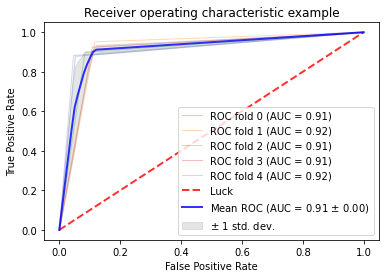

91.25% (+/- 0.44%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  167356416   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]']            
                                tentions(last_hidde                                               
                                n_state=(None, 22,                         

In [ ]:
#Kfold CrossVal

from sklearn.metrics import classification_report
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)
kfold = kfold.split(input_ids, y=tags)
cvscores = []
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)

i = 0
opt = keras.optimizers.Adam(learning_rate=1e-05)
for i, (train, test) in enumerate(kfold):

  traindata = [input_ids[train],attention_masks[train]]
  testdata = [input_ids[test],attention_masks[test]]
  ytrain = tags.iloc[train]
  ytest = tags.iloc[test]

  
  print("Running Fold", i+1, "/", n_folds)
  
  bert_model2 = createmodel()

  bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
  bert_model2.fit(traindata, ytrain, epochs=4,verbose=1,batch_size=16)
  logits = bert_model2.predict(testdata)
  #print(logits) #kalo pake bert layer, ini ga usah tuple langsung aja
  predicts=(logits > 0.5).astype("int32")
  scores = bert_model2.evaluate(testdata, ytest, verbose=0)

  cm = confusion_matrix(ytest, predicts)
  creport = classification_report(ytest, predicts)
  print('Confusion matrix')
  print(cm)
  print(creport)
  print("%s: %.2f%%" % (bert_model2.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  # Compute ROC curve and area the curve
  fpr, tpr, thresholds = roc_curve(ytest, predicts)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print('AUC')
  print(roc_auc)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i += 1
  keras.backend.clear_session()

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

bert_model2.summary()

In [ ]:
#save Model for Production ^^

xtraining = [input_ids,attention_masks]
ytraining = tags
opt = keras.optimizers.Adam(learning_rate=1e-05)
bert_model2 = createmodel()

bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])

bert_model2.fit(xtraining, ytraining, epochs=4, verbose=1,batch_size=16)

loading configuration file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/af4e101d208f361f141144dca21e9c4148aaf0e85441c2e335743d10829c6cad.d63adade93e44e64bedd306ec82ffd33eedabaf0ff08aabe581acaa48616a508
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "ty

Epoch 1/4
415/415 [==============================] - 63s 105ms/step - loss: 0.3178 - accuracy: 0.8610
Epoch 2/4
415/415 [==============================] - 44s 105ms/step - loss: 0.1649 - accuracy: 0.9370
Epoch 3/4
415/415 [==============================] - 44s 105ms/step - loss: 0.1029 - accuracy: 0.9614
Epoch 4/4
396/415 [===========================>..] - ETA: 1s - loss: 0.0630 - accuracy: 0.9787

In [ ]:
# Saving model 
bert_model2.save("/content/drive/MyDrive/Model_mbert.h5", save_format="h5")

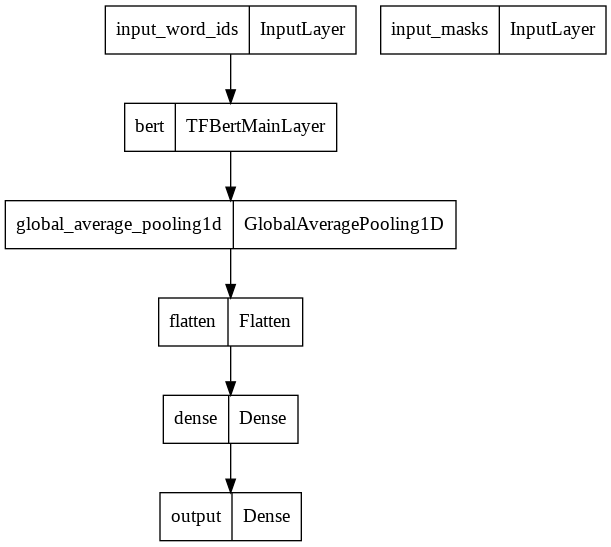

In [ ]:
keras.utils.plot_model(bert_model2)